<a href="https://colab.research.google.com/github/kaleem500bc/Transformer/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import typing
from matplotlib import pyplot as plt
import yaml
#For debugging
import pdb

class Config(object):

  def __init__(self, config_path):

    with open(config_path) as yml:
      self.config = yaml.safe_load(yml.read())

  def __setitem__(self, __name: str, __value) -> None:
    self.config[__name] = __value

  def __getitem__(self, __name: str):

    __name = __name.split("/")
    attribute = self.config[__name[0]]
    for att in __name[1:]:
      attribute = attribute[att]
    return attribute


root = "/content"
yml_file = f"{root}/parameters.yaml"
config = Config(yml_file)

device = "cuda" if torch.cuda.is_available() else "cpu"

#For reproduciblity
torch.manual_seed(1337)

#Download training set
!wget -O "dataset.txt" "https://raw.githubusercontent.com/udacity/deep-learning/master/tensorboard/anna.txt"

#load raw text (dataset)
with open(config["dataset/dataset_file_name"], "r") as f:
  text = f.read()
# text = text.split()
vocabulary = sorted(list(set(text)))

config["vocab_size"] = len(vocabulary)

--2023-04-06 03:34:57--  https://raw.githubusercontent.com/udacity/deep-learning/master/tensorboard/anna.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2025486 (1.9M) [text/plain]
Saving to: ‘dataset.txt’

dataset.txt         100%[===================>]   1.93M  --.-KB/s    in 0.01s   

2023-04-06 03:34:57 (187 MB/s) - ‘dataset.txt’ saved [2025486/2025486]



In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import typing
from matplotlib import pyplot as plt
import yaml
#For debugging
import pdb

class Config(object):

  def __init__(self, config_path):

    with open(config_path) as yml:
      self.config = yaml.safe_load(yml.read())

  def __setitem__(self, __name: str, __value) -> None:
    self.config[__name] = __value

  def __getitem__(self, __name: str):

    __name = __name.split("/")
    attribute = self.config[__name[0]]
    for att in __name[1:]:
      attribute = attribute[att]
    return attribute


root = "/content"
yml_file = f"{root}/parameters.yaml"
config = Config(yml_file)

device = "cuda" if torch.cuda.is_available() else "cpu"

#For reproduciblity
torch.manual_seed(1337)

#Download training set
!wget -O "dataset.txt" "https://raw.githubusercontent.com/udacity/deep-learning/master/tensorboard/anna.txt"

#load raw text (dataset)
with open(config["dataset/dataset_file_name"], "r") as f:
  text = f.read()
# text = text.split()
vocabulary = sorted(list(set(text)))

config["vocab_size"] = len(vocabulary)

--2023-04-06 03:34:57--  https://raw.githubusercontent.com/udacity/deep-learning/master/tensorboard/anna.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2025486 (1.9M) [text/plain]
Saving to: ‘dataset.txt’

dataset.txt         100%[===================>]   1.93M  --.-KB/s    in 0.01s   

2023-04-06 03:34:57 (187 MB/s) - ‘dataset.txt’ saved [2025486/2025486]



In [ ]:
#Tokenize the vocab
stoi = {wrd:i+1 for i, wrd in enumerate(vocabulary)}
itos = {i+1:wrd for i, wrd in enumerate(vocabulary)}

#Words to integers
def encode(string:list) -> torch.Tensor: 
  return torch.tensor([stoi[word] for word in string], dtype = torch.long, device=device)

#Integers to words
def decode(ints:list) -> str:
  return ''.join([itos[i] for i in ints])


In [ ]:
#Simple FeedForwad module
class FeedForward(nn.Module):
  def __init__(self, n_embd:int):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(config["hyperparameters/dropout"]),
    )
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.net(x)

In [ ]:
#Attention Head where relevance of each word in a context is calculated in relation to a given word
class Head(nn.Module):
  def __init__(self, head_size):
    super().__init__()
    n_embd = config["hyperparameters/n_embd"]
    block_size = config["hyperparameters/block_size"]
    self.key = nn.Linear(n_embd, head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)

    #Mask future token so they do not contribute while predicting the next token
    self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    self.dropout = nn.Dropout(config["hyperparameters/dropout"])
  
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    B,T,C = x.shape
    k = self.key(x)
    q = self.query(x)

    # Scale values of Q*K gives more diffused values when apply softmax
    attention = q @ (k.transpose(-2,-1) * C**-0.5) 

    # Only token from the past contribute in predicting the next token
    attention = attention.masked_fill(self.tril[:T,:T] == 0, float('-inf'))
    attention = F.softmax(attention, dim=-1)

    #For better regularization
    attention = self.dropout(attention) 

    v = self.value(x)
    attention = attention @ v
    return attention

In [ ]:
#Instantiate multiple Attention Head
class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads, head_size):
    super().__init__()
    n_embd = config["hyperparameters/n_embd"]
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd)
    self.dropout = nn.Dropout(config["hyperparameters/dropout"])
  
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    #Concatenate output of each Attention Head
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out


In [ ]:
#A Block consist of MultiHeadAttention, LayerNorm and a FeedForward module
class Block(nn.Module):
  def __init__(self, n_embd, num_of_attention_head):
    super().__init__()
    head_size = n_embd // num_of_attention_head
    self.multiHeadAttention = MultiHeadAttention(num_of_attention_head, head_size)
    self.ffwd = FeedForward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)
  
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    #Skip connection and apply layerNorm
    x = x + self.multiHeadAttention(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x


In [ ]:
class LanguageModel(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.model_checkpoint_path = config["training/model_checkpoint_path"]

    self.training_dataloader = config.train_dataloader
    self.val_dataloader = config.val_dataloader
    self.train_len = len(config.train_dataloader)
    self.val_len = len(config.val_dataloader)

    self.token_embedding_table = nn.Embedding(config["vocab_size"], config["hyperparameters/n_embd"])
    self.position_embedding_table = nn.Embedding(config["hyperparameters/block_size"], config["hyperparameters/n_embd"])
    blocks = [Block(config["hyperparameters/n_embd"], config["hyperparameters/num_of_attention_head"]) for _ in range(config["hyperparameters/size_of_attention_head"])]
    self.blocks = nn.Sequential(*blocks)
    self.ln_f = nn.LayerNorm(config["hyperparameters/n_embd"])
    self.lm_head = nn.Linear(config["hyperparameters/n_embd"], config["vocab_size"])
  
  def forward(self, idx:torch.Tensor, targets:torch.Tensor=None) -> tuple:
    B, T = idx.shape
    token_emb = self.token_embedding_table(idx)

    #Encode positional embeding of a word in a sequence
    pos_emb = self.position_embedding_table(torch.arange(T, device=device))
    x = token_emb + pos_emb

    x = self.blocks(x)
    x = self.ln_f(x)
    logits = self.lm_head(x)
    if targets is None:
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
    return logits, loss

  @torch.no_grad()
  def evaluate_model(self):
    eval_loss = 0
    self.eval()
    for input_seq, target_seq in config.val_dataloader:
      _, loss = self(input_seq, target_seq)
      eval_loss += loss.item()
    self.train()
    return eval_loss

  def train_model(self, optim):
    loss_per_epoch = []
    complete_eval_loss = [float('inf')]
    patience = config["training/patience"]
    for epoch in range(config["training/epochs"]):

      epoch_loss = 0
      for input_seq, target_seq in config.train_dataloader:
        _, loss = self(input_seq, target_seq)
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_loss += loss.item()

      epoch_loss = round(epoch_loss / self.train_len, 4)
      eval_loss = round(self.evaluate_model() / self.val_len, 4)

      print(f"Epoch {epoch}: {epoch_loss}, Evaluation Loss: {eval_loss}")

      if eval_loss < complete_eval_loss[-1]:
        complete_eval_loss.append(eval_loss)
        
        #Save model checkpoint if evaluation loss decreases
        torch.save(self.state_dict, config["training/model_checkpoint_path"])
        patience = config["training/patience"]

      elif patience <= 0:
        #Stop training if evaluation loss did not decrease for "patience" number of epochs
        return loss_per_epoch, complete_eval_loss[1:]
      else:
        #decrement patience if evaluation loss did not decrease
        patience -= 1

      loss_per_epoch.append(epoch_loss)
    
    return loss_per_epoch, complete_eval_loss[1:]



  #idx are given tokens
  #max_new_tokens are maximum number of tokens that should be generated
  @torch.no_grad()
  def generate(self, idx:torch.Tensor) -> torch.Tensor:
    self.eval()
    for _ in range(config["max_new_tokens"]):
      idx_cond = idx[:, -config["hyperparameters/block_size"]:]
      logits, _ = self(idx_cond)
      logits = logits[:, -1, :]
      probs = F.softmax(logits, dim = -1)
      idx_next = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, idx_next), dim=1)
    self.train()
    return idx


In [ ]:
#Custom dataset
class Dataset(Dataset):

  def __init__(self, config):
    block_size = config["hyperparameters/block_size"]

    #turncate last sequence that does not have block_size length
    dataset_offset = len(config["encoded_text"]) // block_size
    config["encoded_text"] = config["encoded_text"][:block_size * dataset_offset]

    dataset_len = len(config["encoded_text"]) 
    

    #Raise exception if block size is less than length of the dataset
    if dataset_len - block_size < 0:
      raise Exception(f"Block Size {block_size} must be less then dataset size {dataset_len}.")

    self.dataset = config["encoded_text"].to(device)

  def __getitem__(self, idx:int) -> torch.Tensor:
    inputs = self.dataset[idx : idx+config["hyperparameters/block_size"]]
    targets = self.dataset[idx+1 : idx+1+config["hyperparameters/block_size"]]
    return inputs, targets

  def __len__(self):
    return len(config["encoded_text"]) // config["hyperparameters/block_size"]
  

#Encode text dataset to integers
config["encoded_text"] = encode(text)

#Instantiate dataset
dataset = Dataset(config)
train_set, val_set = random_split(dataset, [0.8, 0.2])

#Instantiate dataloaders
config.train_dataloader = DataLoader(train_set, batch_size=config["hyperparameters/batch_size"], shuffle=True)
config.val_dataloader = DataLoader(val_set, batch_size=config["hyperparameters/batch_size"])

In [ ]:
filename_save_model = "language_model.pt"
language_model = LanguageModel(config)
language_model.to(device)

optim = torch.optim.AdamW(language_model.parameters(), lr = float(config["hyperparameters/learning_rate"]))

In [ ]:
train_loss, eval_loss = language_model.train_model(optim)

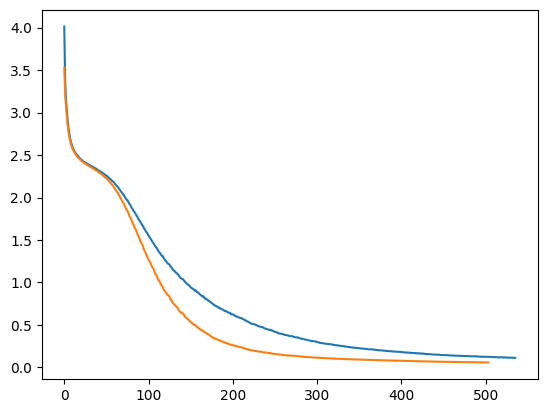

In [ ]:
plt.plot(train_loss)
plt.plot(eval_loss)
plt.show()

In [ ]:
language_model.eval()
input = "I was going"
input = encode(input).unsqueeze(0)
config["max_new_tokens"] = 100
print(decode(language_model.generate(input)[0].tolist()))

I was going a dressing-gown always hung in his bedroom. And thereupon he suddenly
remembered that he was not sl
